# CNN+LSTM 전력 수요 예측 

### <목차>

### <화면 가로 확장>

In [1]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import time
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import norm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, LSTM, Bidirectional, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.wrappers import TimeDistributed
import keras

from keras.utils.vis_utils import plot_model
import pydot
import pydotplus
import graphviz

from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [3]:
try:
    os.mkdir('./Result')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


### <GPU 확인>

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

### Data Import

In [56]:
Data_4Y_Edited = pd.read_csv('./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16_Outlier_Edited.csv', encoding='cp949')
Data_4Y_Edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102400 entries, 0 to 2102399
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   Year-Month-Date  object 
 2   Time             object 
 3   Holiday          int64  
 4   Watt             float64
 5   Temp('C)         float64
 6   Humidity(%)      float64
 7   CPI              float64
dtypes: float64(4), int64(2), object(2)
memory usage: 128.3+ MB


#### Graph

In [6]:
#SimpleGraph("1Day Electric Power Data Outlier handled Graph", Data_4Y_Edited["Watt"][5760:7200], "Watt", "1Day_Outlier_Edited_Data_Watt")

### 4. 데이터 정규화

#### Min-Max Scaling 이용, 4년치 학습 데이터 정규화

In [7]:
"""
<StandardScaler>
from sklearn.preprocessing import StandardScaler
평균 0, 분산1 로 조정
가우시안 분포된 선형 데이터나 SVM에 사용

<RobustScaler>
from sklearn.preprocessing import RobustScaler
평균과 분산 대신 중간값과 사분위 값을 사용.
이상치에 Robustic한 반응을 보임.

<MinMaxScaler>
모든 값을 0~1 사이로 정규화
원데이터 분포를 유지하면서 정규화하는 방법
가우시안 분포를 띄지 않는 데이터에 사용

<Normalizer>
from sklearn.preprocessing import Normalizer
특성 벡터의 모든 길이가 1이 되도록 조정, 
특성 벡터의 길이보다는 데이터의 방향이나 각도가 중요할 경우 사용

<QuantileTransformer>
from sklearn.preprocessing import QuantileTransformer
1000개의 분위를 사용하여 데이터를 균등분포 시킴.
Robustic한 특성을 지니며, 데이터들은 0~1 사이로 압축됨.

<PowerTransformer>
from sklearn.preprocessing import PowerTransformer
데이터의 특성별로 정규분포 형태에 가깝도록 변환
"""

'\n<StandardScaler>\nfrom sklearn.preprocessing import StandardScaler\n평균 0, 분산1 로 조정\n가우시안 분포된 선형 데이터나 SVM에 사용\n\n<RobustScaler>\nfrom sklearn.preprocessing import RobustScaler\n평균과 분산 대신 중간값과 사분위 값을 사용.\n이상치에 Robustic한 반응을 보임.\n\n<MinMaxScaler>\n모든 값을 0~1 사이로 정규화\n원데이터 분포를 유지하면서 정규화하는 방법\n가우시안 분포를 띄지 않는 데이터에 사용\n\n<Normalizer>\nfrom sklearn.preprocessing import Normalizer\n특성 벡터의 모든 길이가 1이 되도록 조정, \n특성 벡터의 길이보다는 데이터의 방향이나 각도가 중요할 경우 사용\n\n<QuantileTransformer>\nfrom sklearn.preprocessing import QuantileTransformer\n1000개의 분위를 사용하여 데이터를 균등분포 시킴.\nRobustic한 특성을 지니며, 데이터들은 0~1 사이로 압축됨.\n\n<PowerTransformer>\nfrom sklearn.preprocessing import PowerTransformer\n데이터의 특성별로 정규분포 형태에 가깝도록 변환\n'

In [57]:
# 정규화 과정을 거쳐 데이터 범위를 원하는 범위로 제한. 그래프는 동일하나 손실 정도를 확인하기에 더 좋음.
# 배치 정규화는 기울기 소멸 문제를 해결하기는 좋으나, RNN의 경우 계층별로 미니 정규화 적용이 필요해 모델이 복잡해지고 효율이 저하됨.
Data_4Y_Edited.sort_index(ascending=False).reset_index(drop=True)
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
scaler=QuantileTransformer()
Scaler_Name=str(scaler)[:-2]

#scale_cols = ["Holiday", "Watt", "Temp('C)", "Humidity(%)", "CPI"]
Data_4Y_Edited.insert(2, "Watt2", Data_4Y_Edited["Watt"])
scale_cols = ["Watt", "Watt2"]
Data_4Y_scaled = scaler.fit_transform(Data_4Y_Edited[scale_cols])
Data_4Y_scaled = pd.DataFrame(Data_4Y_scaled)
Data_4Y_scaled.columns = scale_cols

#Data_4Y_scaled=Data_4Y_scaled[["Watt", "Watt2"]]
Data_4Y_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102400 entries, 0 to 2102399
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Watt    float64
 1   Watt2   float64
dtypes: float64(2)
memory usage: 32.1 MB


In [58]:
scaler1=QuantileTransformer()
Data_4Y_Edited["Watt"]=scaler1.fit_transform(Data_4Y_Edited["Watt"].values.reshape(-1,1))

#### 정규분포 시각화

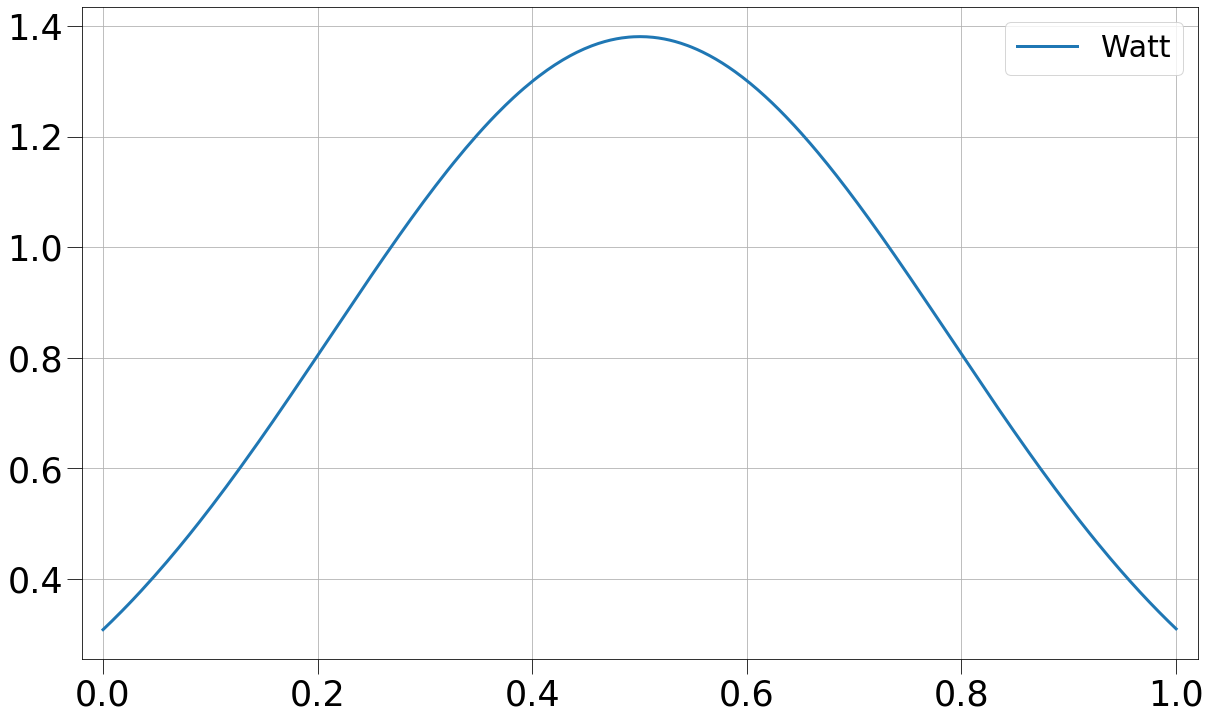

In [63]:
plt.figure(figsize=(20,12))
plt.grid()
#plt.title("Normal Distribution", fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=35)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=35)
#plt.plot(np.sort(Data_4Y_scaled["Humidity(%)"]), norm.pdf(np.sort(Data_4Y_scaled["Humidity(%)"]), np.mean(Data_4Y_scaled["Humidity(%)"]), np.std(Data_4Y_scaled["Humidity(%)"])), label="Humidity", linewidth=3)
plt.plot(np.sort(Data_4Y_scaled["Watt"]), norm.pdf(np.sort(Data_4Y_scaled["Watt"]), np.mean(Data_4Y_scaled["Watt"]), np.std(Data_4Y_scaled["Watt"])), 
         label="Watt", linewidth=3)
#plt.plot(np.sort(Data_4Y_scaled["Temp('C)"]), norm.pdf(np.sort(Data_4Y_scaled["Temp('C)"]), np.mean(Data_4Y_scaled["Temp('C)"]), np.std(Data_4Y_scaled["Temp('C)"])), label="Temp", linewidth=3)
plt.legend(fontsize=30)
plt.margins(x=0.02)
if Scaler_Name=="RobustScaler":
    print(Scaler_Name)
    plt.xlim([-5.2, 7.6])
elif Scaler_Name=="PowerTransformer":
    plt.xlim([-2.5, 2.5])
plt.savefig("./Result/Data_Normal_Distribution_"+Scaler_Name+".png")
plt.show()   

#### 전력 데이터 변화폭 재확인

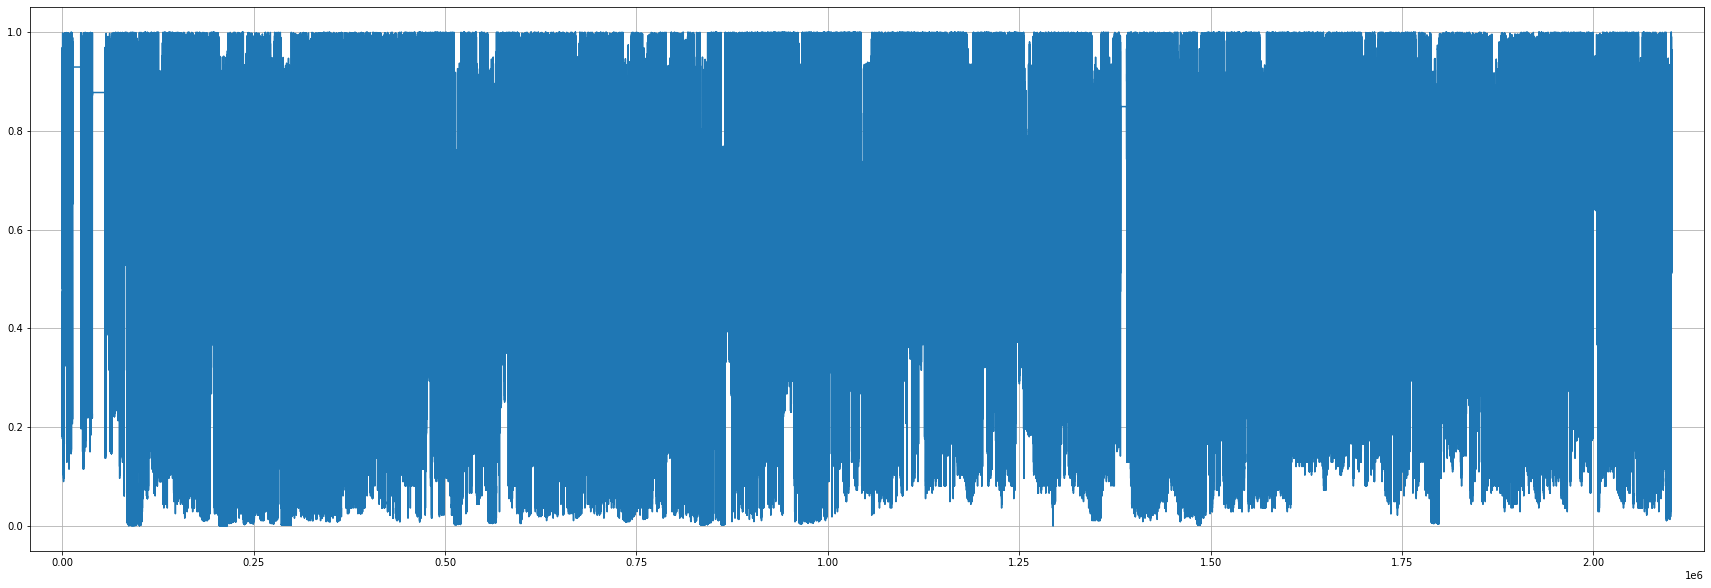

In [11]:
plt.figure(figsize=(30,10))
plt.grid()
plt.margins(x=0.02)
plt.plot(Data_4Y_scaled["Watt"])
#plt.plot(inverse_scaled_data)
plt.show()

### 7. 데이터셋 편집

In [64]:
TEST_SIZE = 1*60*24*365 #1년치를 테스트셋으로 사용
WINDOW_SIZE = 5 #얼마 동안의 과거 기반의 데이터로 다음값을 예측할 것인지 설정. 
BATCH_SIZE = 64
VAL_DAYS = 525600

In [65]:
# train과 test셋 분할
learning = Data_4Y_scaled[:-TEST_SIZE] # 학습에 쓰이는 전체 데이터
VAL_RATIO=VAL_DAYS/len(learning)
VAL_SIZE = int(len(learning)*VAL_RATIO)
TRAIN = learning[:-VAL_SIZE]
VAL = learning[-VAL_SIZE:]
TEST = Data_4Y_scaled[-TEST_SIZE:]
print(len(TRAIN), len(VAL), len(TEST))

1051200 525600 525600


In [66]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [67]:
train_data = windowed_dataset(TRAIN, WINDOW_SIZE, BATCH_SIZE, False) 
valid_data = windowed_dataset(VAL, WINDOW_SIZE, BATCH_SIZE, False)
test_data = windowed_dataset(TEST, WINDOW_SIZE, BATCH_SIZE, False)

### 8. 딥러닝 모델

In [90]:
LeakyReLU=tf.keras.layers.LeakyReLU(alpha=0.1)

model = Sequential([
    Conv1D(filters=8, kernel_size=4, padding="causal", activation=LeakyReLU, input_shape=[WINDOW_SIZE, TRAIN.shape[1]]),
    MaxPooling1D(pool_size=2, strides=1, padding="same"),
    Conv1D(filters=8, kernel_size=4, padding="causal", activation=LeakyReLU),
    MaxPooling1D(pool_size=2, strides=1, padding="same"),
    Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode="ave"),
    TimeDistributed(Dense(8)),
    Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode="ave"),
    TimeDistributed(Dense(4)),
    Bidirectional(LSTM(2, activation=LeakyReLU, return_sequences=False), merge_mode="ave"),
    Dense(1)
                    ])


Nadam = tf.keras.optimizers.Nadam(learning_rate=0.0003)
model.compile(loss='mean_absolute_error', optimizer=Nadam)
print('\n'*4)
model.summary()






Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 5, 8)              72        
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 5, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 5, 8)              264       
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 5, 8)             0         
 g1D)                                                            
                                                                 
 bidirectional_33 (Bidirecti  (None, 5, 4)             416       
 onal)                                                           
                                                

#### Plot model 저장

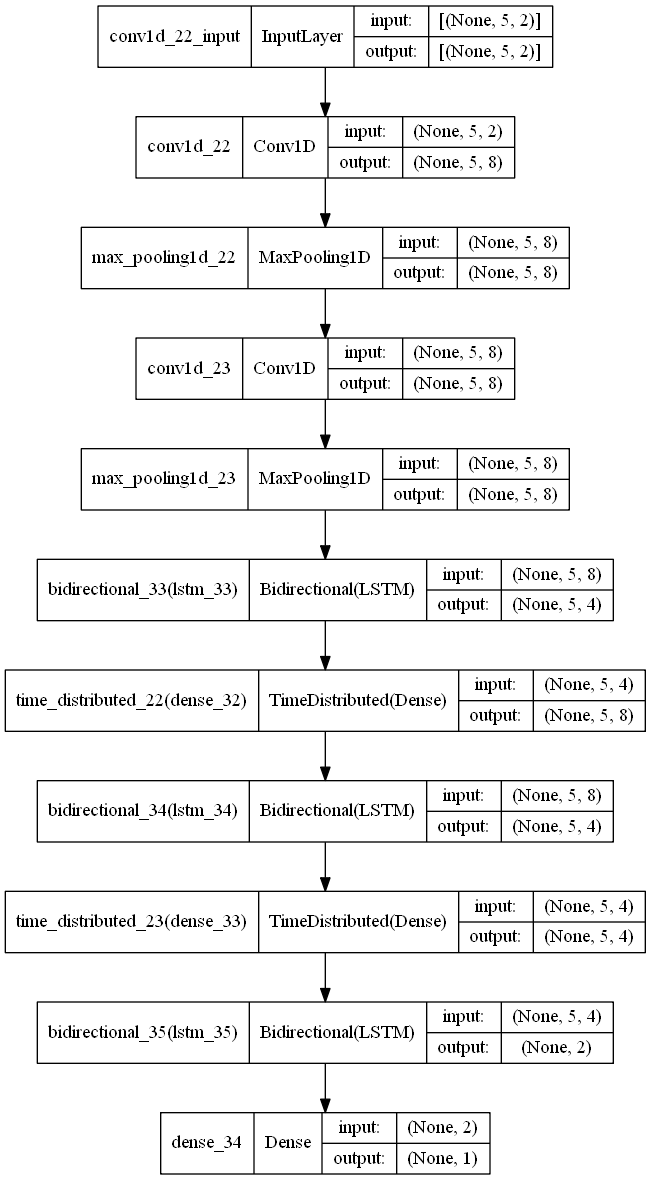

In [91]:
plot_model(model, to_file='./Result/CNN+LSTM/model.png')
plot_model(model, to_file='./Result/CNN+LSTM/model_shapes.png', show_shapes=True)

#### 학습

In [ ]:
start=datetime.datetime.now()
early_stop = EarlyStopping(monitor='val_loss', patience=10)

with tf.device('/GPU:0'):
    model_path = 'model'
    filename = os.path.join(model_path, "tmp_checkpoint_main.h5")
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    history = model.fit(train_data, epochs=10, batch_size=BATCH_SIZE, validation_data=(valid_data), callbacks=[checkpoint, early_stop])

model.load_weights(filename)
pred = model.predict(test_data)
pred.shape
end=datetime.datetime.now()
print("\n소요시간 >>", end-start)

Epoch 1/10
    613/Unknown - 79s 121ms/step - loss: 0.1530

In [ ]:
model.load_weights(filename)
pred = model.predict(test_data)
pred.shape

### 9. 결과 표시

In [ ]:
try:
    os.mkdir('./Result/CNN+LSTM')
    os.mkdir('./Result/CNN+LSTM/Graph')
    os.mkdir('./Result/CNN+LSTM/Data')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

In [ ]:
plt.figure(figsize=(20, 12))
plt.title('Model Validation Loss', fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=30)
#plt.xticks(range(0,len(history.history['val_loss'])), labels=range(1,len(history.history['val_loss'])+1))
plt.xlabel('[Epoch]', size=30)
plt.ylabel('[Val_loss]', size=30)
plt.grid(True)
plt.plot(history.history['val_loss'])
plt.margins(x=0.02)
plt.savefig("./Result/CNN+LSTM/Graph/Model_Valdation_Loss_"+Scaler_Name+".png")
plt.show

In [ ]:
plt.figure(figsize=(20, 12))
plt.title('Model Loss Convergence Graph - '+Scaler_Name, fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=30)
#plt.xticks(range(0,len(history.history['val_loss'])), labels=range(1,len(history.history['val_loss'])+1))
y_tloss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(len(y_tloss))
plt.xlabel('[Epoch]', size=30)
plt.ylabel('[Loss=MAE]', size=30)
plt.grid(True)
plt.plot(x_len, y_tloss, "o-", c="blue", markersize=3)
plt.plot(x_len, y_vloss, "o-", c="red", markersize=3)
plt.margins(x=0.02)
plt.legend(['Training loss', 'Validation loss'], fontsize=20)
plt.savefig("./Result/CNN+LSTM/Graph/Model_Loss_Convergence_Graph_"+Scaler_Name+".png")
plt.show

In [ ]:
Inversed_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))
Inversed_true = scaler1.inverse_transform(np.array(TEST['Watt'][:-WINDOW_SIZE]).reshape(-1,1))

In [ ]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', size=20)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=20)
plt.tick_params(axis='y', labelsize=30)

plt.plot(Inversed_pred, label = 'Prediction',color='blue')

plt.xticks([0, 31*24*60, 59*24*60, 90*24*60, 120*24*60, 151*24*60, 181*24*60, 212*24*60, 243*24*60, 273*24*60, 304*24*60, 334*24*60], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.yticks(range(0,10000,1000), labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W', '9000 W'])

plt.margins(x=0.005)
#plt.savefig('./Result/CNN+LSTM/Graph/Prediction.png')
plt.show()

In [ ]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', size=20)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=20)
plt.tick_params(axis='y', labelsize=30)

plt.plot(Inversed_true, label = 'Actual', color='darkorange')

plt.xticks([0, 31*24*60, 59*24*60, 90*24*60, 120*24*60, 151*24*60, 181*24*60, 212*24*60, 243*24*60, 273*24*60, 304*24*60, 334*24*60], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks(range(0,10000,1000), 
               labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W', '9000 W'])

plt.margins(x=0.005)
#plt.savefig('./Result/CNN+LSTM/Graph/Actual.png')
plt.show()

In [ ]:
plt.figure(figsize=(300, 15))
plt.title('Electric power predict with actual graph', fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=30)

x_len = np.arange(len(pred))

plt.xticks([0, 1440*31, 1440*59, 1440*90, 1440*120, 1440*151, 1440*181, 1440*212, 1440*243, 1440*273, 1440*304, 1440*334], labels=range(1, 13))
plt.yticks(range(0,10000,1000), labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W', '9000 W'])
plt.xlabel('[Month]', size=30)
plt.ylabel('[Watt]', size=30)

plt.plot(x_len, Inversed_true, "-", c="blue", markersize=3)
plt.plot(x_len, Inversed_pred, "-", c="darkorange", markersize=3)


plt.margins(x=0.002)
plt.legend(['Actual', 'Predict'], fontsize=30, loc=1, bbox_to_anchor=(0.994, 1, 0, 0))
plt.savefig("./Result/CNN+LSTM/Graph/Predict_With_Actual_Graph_"+Scaler_Name+".png")
plt.show

In [ ]:
plt.figure(figsize=(20, 12))
plt.title('Electric power predict graph - '+Scaler_Name, fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=30)

x_len = np.arange(len(pred[0:1440*7]))

plt.xticks(range(0,len(pred[0:1440*7]), 1440), labels=range(1, 8))
plt.yticks(range(0,10000,1000), labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W', '9000 W'])

plt.xlabel('[Days]', size=30)
plt.ylabel('[Watt]', size=30)

plt.plot(x_len, Inversed_true[WINDOW_SIZE:1440*7+WINDOW_SIZE], "-", c="darkorange", markersize=3)
plt.plot(x_len, Inversed_pred[0:1440*7], "-", c="blue", markersize=3)

plt.grid(True)
#plt.margins(x=0.02)
plt.legend(['Actual', 'Predict'], fontsize=20)
plt.savefig("./Result/CNN+LSTM/Graph/Predict_With_Actual_Graph_Week_"+Scaler_Name+".png")
plt.show

### 정규화 상태의 수치 결과
#### #역정규화를 한 상태로 비교하면 성능평가지표에서 간편하게 비교가 불가능.

In [ ]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

def smape(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean((np.abs(y_test-y_pred))/(np.abs(y_test)+np.abs(y_pred)))*100/2

In [ ]:
true = TEST['Watt2'][:-WINDOW_SIZE].to_numpy()
true = true.reshape(-1,1)

RMSE = np.sqrt(MSE(true, pred))

In [ ]:
print('r2 >> %.4f' %r2(true, pred)) # 1에 가까워야 좋음
print('MAE >> %.4f' %mae(true, pred)) # 0에 가까워야 좋음
print('RMSE >> %.4f' %RMSE) # 0에 가까워야 좋음
print('SMAPE >> %.4f' %smape(true, pred)) # 0에 가까워야 좋음